# Анализ пространственных данных. Домашнее задание №2

Мягкий дедлайн: __4 ноября 2020 г. 23:59__

Жесткий дедлайн (со штрафом в _50%_ от количества набранных вами за ДЗ баллов): __5 ноября 2020 г. 08:59__

Визуализация "чего-либо" __без__ выполненного основного задания оценивается в __0 баллов__

ФИО: `Хныков Ярослав Станиславович`

Группа: `DS-11`

## Задание №1. Горячая точка (алгоритм - 10 баллов, визуализация - 10 баллов).

Генерируйте рандомные точки на планете Земля до тех пор, пока не попадете на территорию ``Афганистана``

1. Вы можете использовать функции принадлжености точки полигону и расстояния от точки до полигона (в метрах)
2. Предложите не наивный алгоритм поиска (генерировать __напрямую__ точку из полигона границ Афганистана __запрещено__)

Визуализируйте пошагово предложенный алгоритм при помощи ``Folium``

In [1]:
import pandas as pd
import folium
from folium.plugins import TimestampedGeoJson, MiniMap
from shapely.geometry import Point, Polygon, LineString, mapping
from shapely.ops import cascaded_union
import random
from geopy.distance import distance
from scipy.misc import derivative
from datetime import datetime as dt
from datetime import timedelta
import requests
from OSMPythonTools.overpass import Overpass, overpassQueryBuilder
from OSMPythonTools.nominatim import Nominatim
import warnings
from openrouteservice import client
warnings.filterwarnings("ignore")

In [2]:
def polygon_from_relation(relation_id):
    resp = requests.get(f"http://polygons.openstreetmap.fr/get_geojson.py?id={relation_id}&params=0").json()
    
    points = []
    for point in resp["geometries"][0]["coordinates"][0][0]:
        lon, lat = point
        p = Point(lon, lat)
        points.append(p)
    
    polygon = Polygon(points)
    return polygon

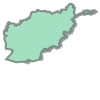

In [3]:
af_borders = polygon_from_relation(303427)
af_borders

In [4]:
def random_point():
    lat = random.uniform(-90, 90)
    lon = random.uniform(-180, 180)
    return Point(lon, lat)

In [5]:
not_found = True
while not_found:
    rand_point = random_point()
    if rand_point.within(af_borders):
        not_found = False

af_capital = [34.515345, 69.176134]        
m = folium.Map(location=af_capital, zoom_start=6)
folium.GeoJson(af_borders).add_to(m)
folium.GeoJson(rand_point).add_to(m)
m

In [6]:
af_centroid = af_borders.centroid
c_lon, c_lat = af_centroid.coords[0]


def adjust_longitude(x):
    return (x + 180) % 360 - 180


def adjust_latitude(x):
    return (x + 90) % 180 - 90


def haversine_distance(lon, lat, lon0=c_lon, lat0=c_lat):
    point = (adjust_latitude(lat), adjust_longitude(lon))
    point0 = (adjust_latitude(lat0), adjust_longitude(lon0))
    return distance(point, point0).km


def partial_derivative(func, point):
    _args = point[:]
    var_count = len(point)
    res = [None] * var_count
    for var_idx in range(var_count):
        args = _args[:]
        def f(x):
            args[var_idx] = x
            return func(*args)
        res[var_idx] = derivative(f, args[var_idx], dx=0.5)
    return res


def gradient_descent(func, init=None, iterations=1000, step=0.02, path=None):
    if path is None:
        path = []
    if init is None:
        init = [*random_point().coords[0]]
        path.append(init)
    
    lon, lat = init
    dlon, dlat = partial_derivative(haversine_distance, [lon, lat])
    
    init = [adjust_longitude(lon - step * dlon), adjust_latitude(lat - step * dlat)]
    path.append(init)
    iterations -= 1
    if Point(init).within(af_borders) or not iterations:
        return init, path
    
    return gradient_descent(func, init=init, iterations=iterations, path=path)

In [7]:
def linestring_feature(path, init_time=dt(2020, 1, 1).date()):
    feature = {
        "type": "Feature",
        "geometry": {
            "type": "LineString",
            "coordinates": path,
         },
        "properties": {
            "icon": "marker",
            "iconstyle": {
                "iconUrl": "https://i.pinimg.com/originals/e9/0a/29/e90a299a041b7d37cdafc6eb2905e9d6.png", 
                'iconSize': (20, 20)
            },
            "style": {
                "color": "black"
            },
            "times": [(init_time + timedelta(days=2 * i)).strftime("%Y-%m-%d") for i, _ in enumerate(path)]
         }
    }
    return feature

In [8]:
af_point, path = gradient_descent(haversine_distance)

line_string_features = [linestring_feature(path)]
m = folium.Map()
folium.GeoJson(af_borders).add_to(m)
TimestampedGeoJson({
    "type": "FeatureCollection",
    "features": line_string_features
}, transition_time=30, period="P1D", add_last_point=True).add_to(m)
m

## Задание №2. Качество жизни (20 баллов).

Для измерения показателя качества жизни в точке, найденной в предыдущем задании, вам необходимо рассчитать следующую сумму расстояний (в метрах):

1. Расстояние от точки до 5 ближайших __*__ банкоматов, находящихся в стране с наибольшим количеством объектов жилой недвижимости
2. Расстояние от точки до 5 ближайших школ, находящихся в стране с наибольшим количеством аптек в столице
3. Расстояние от точки до 5 ближайших кинотеатров, наодящихся в стране с самым большим отношением числа железнодорожных станций к автобусным остановкам в южной части __**__

__*__ При поиске _N_ ближайших объектов обязательно использовать ``R-tree``

__**__ Южной частью страны является территория, находящаяся к югу от множества точек, равноудаленных от самой северной и самой южной точек страны

In [9]:
overpass = Overpass()

countries = overpass.query(
"""
area[admin_level=2][boundary=administrative];
out;
""", timeout=10000).toJSON()["elements"]

_country_id = {c["id"]: c["tags"]["name"] for c in countries if c["id"] % 10 == 0}

country_id = {v: [] for v in _country_id.values()}
for k, v in _country_id.items():
    country_id[v].append(k)

In [10]:
id_house_count = {}
for id_ in _country_id:
    query = overpassQueryBuilder(
    area=id_, 
    elementType="nwr", 
    selector="'building'~'apartments|bungalow|cabin|detached|dormitory|farm|ger|hotel|house|houseboat|residential|semidetached_house|static_caravan|terrace'", 
    out="count"
    )
    res = int(overpass.query(query, timeout=10000).toJSON()["elements"][0]["tags"]["total"])
    id_house_count[id_] = res

In [11]:
house_count = {c: 0 for c in country_id}

for c in house_count:
    for id_ in country_id[c]:
        house_count[c] += id_house_count[id_]

In [12]:
most_houses_country = max(house_count.items(), key=lambda x: x[1])[0]
print(most_houses_country)

Brasil


In [13]:
nominatim = Nominatim()
area_id = nominatim.query(most_houses_country).areaId()

atm = overpass.query(
    overpassQueryBuilder(area=area_id, elementType="nwr", selector="amenity='atm'", out="geom"),
    timeout=10000
).toJSON()["elements"]

## Задание №3. Поездка по Нью-Йорку (маршрут - 20 баллов, визуализация - 10 баллов).

Добраться __на автомобиле__ от входа в ``Central Park`` __Нью-Йорка__ (со стороны ``5th Avenue``) до пересечения ``Water Street`` и ``Washington Street`` в Бруклине (откуда получаются лучшие фото Манхэттенского моста) довольно непросто - разумеется, из-за вечных пробок. Однако еще сложнее это сделать, проезжая мимо школ, где дети то и дело переходят дорогу в неположенном месте.

Вам необходимо построить описанный выше маршрут, избегая на своем пути школы. Визуализируйте данный маршрут (также добавив школы и недоступные для проезда участки дорог) при помощи ``Folium``

Данные о расположении школ Нью-Йорка можно найти [здесь](https://catalog.data.gov/dataset/2019-2020-school-point-locations)

In [14]:
schools = pd.read_csv(
    "https://data.cityofnewyork.us/api/views/a3nt-yts4/rows.csv?accessType=DOWNLOAD"
)["the_geom"].str.strip('POINT ()').str.split().apply(lambda x: Point(*map(float, x))).values

In [15]:
def style_function(color):
    return lambda feature: dict(color=color, opacity=0.9, weight=4)


api_key = "5b3ce3597851110001cf6248090c01452b03477a85fb517f66684912"
clnt = client.Client(key=api_key)

coordinates = [[-73.961044, 40.780865], [-73.989561, 40.703572]]
regular_request = {
    "coordinates": coordinates,
    "profile": "driving-car", 
    "format_out": "geojson",
    "preference": "shortest",
    "geometry": "true"
}
regular_route = clnt.directions(**regular_request)

area = LineString([Point(coordinates[0]), Point(coordinates[1])]).buffer(0.04)
avoid_schools = [(sch, sch.buffer(0.0013)) for sch in schools if sch.within(area)]

avoid_request = {
    "coordinates": coordinates, 
    "format_out": "geojson",
    "profile": "driving-car",
    "preference": "shortest",
    "instructions": False,
    "options": {"avoid_polygons": mapping(cascaded_union([sch[1] for sch in avoid_schools]))}
} 
avoid_route = clnt.directions(**avoid_request)

regular_popup = folium.map.Popup("<h6>Regular Route</h6>")
avoid_popup = folium.map.Popup("<h6>Avoid Schools Route</h6>")

edu_url = "http://getdrawings.com/free-icon-bw/seahawks-icon-1.png"
m = folium.Map(location=coordinates[0][::-1], zoom_start=13.5, tiles="Stamen Terrain")
folium.GeoJson(regular_route, style_function=style_function("blue")).add_child(regular_popup).add_to(m)
folium.GeoJson(avoid_route, style_function=style_function("#00FF00")).add_child(avoid_popup).add_to(m)
folium.Marker(coordinates[0][::-1]).add_to(m)
folium.Marker(coordinates[1][::-1]).add_to(m)
for sch in avoid_schools:
    point, buff = sch
    folium.Marker(point.coords[0][::-1], icon=folium.features.CustomIcon(edu_url, icon_size=(15, 15))).add_to(m)
    folium.GeoJson(buff, style_function=style_function("red")).add_to(m)
m